In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import ot
import seaborn as sns
sns.set_style("white")
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from labellines import labelLine, labelLines
from solvers import solvers_L2_UOT as sl2

### Useful functions

In [2]:
# Compute H^TH
def compute_hth(active_i, active_j):
    k = len(active_i)
    H = np.zeros((k, k))
    for i in range(k):
        for j in range(i):
            if active_i[i] == active_i[j]:
                H[i, j] += 1
                H[j, i] += 1
            if active_j[i] == active_j[j]:
                H[i, j] += 1
                H[j, i] += 1  
        H[i, i] = 2
    return H

# Compute the T matrix
def compute_T(active_x, active_y, lambda_c, a, b, C):
    #idxs = np.where(T > 1e-8)
    k = len(active_x)
    c = np.zeros(k)
    m = np.zeros(k)
    for i in range(k):
        c[i] = C[active_x[i], active_y[i]] 
        m[i] = a[active_x[i]] + b[active_y[i]]
        
    hth = compute_hth(active_x, active_y)    
    
    m_tilde = np.linalg.solve(hth, m)
    c_tilde = np.linalg.solve(hth, c)
    t_vec = m_tilde - 1 / (2 * lambda_c) * c_tilde
    
    T_mat = np.zeros((len(a), len(b)))
    #print(t_vec, len(active_x), T_mat)
    for i in range(k):
        T_mat[active_x[i], active_y[i]] = t_vec[i]
    return T_mat

### Definition of a, b and C

In [3]:
np.random.seed(0)
n = 3

xs = np.array([1., 2., 3.]).reshape((n, 1))+ np.random.randn(n, 1) * .01
xt = np.array([5., 6., 7.]).reshape((n, 1))+ np.random.randn(n, 1) * .01

C = ot.dist(xs, xt)
C /= C.max()
a = np.array([0.2, 0.5, 0.3])
b = np.array([0.2, 0.5, 0.3])

### Computation of the whole regularization path

In [7]:
_, _, T_list, lambda_list, _, active_i, active_j = sl2.ot_ul2_reg_path(a, b, C, savePi=True, return_active_set=True)
all_T = np.array([T.toarray() for T in T_list])

In [9]:
more_Ts = []
all_l = []
max_l = 1
lambda_list[-1] = lambda_list[-2] + max_l # avoid infi
for i in range(len(lambda_list)-1):
    for r in np.geomspace(lambda_list[i], lambda_list[i+1],50, endpoint=False):
        more_Ts.append(compute_T(active_i[i], active_j[i], r, a,b,C)) 
        all_l.append(r)

np.insert(lambda_list,0,0)
more_Ts = np.array(more_Ts)
all_l = np.array(all_l)       

### Figure 1

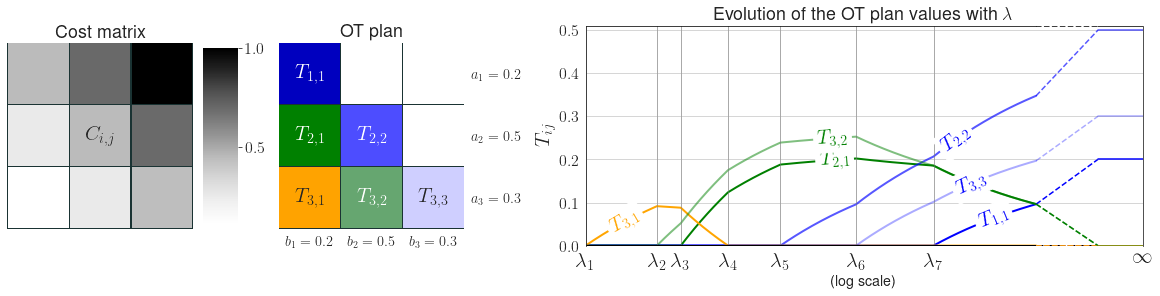

In [11]:
fig = plt.figure(figsize=(16,4), constrained_layout=True)
gs = GridSpec(1, 3, figure=fig, width_ratios=[1,1,3])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "pdf.fonttype": 42,
    "ps.fonttype":42, 
    "font.size": 16})

# Left panel:C matrix------------------------
text = np.array([['', '', ''], ['', '\huge $C_{i,j}$', ''], ['', '', '']])
heatmap = sns.heatmap(C, cmap="Greys", square=True, linewidth=0.1, linecolor=(0.1, 0.2, 0.2), ax=ax1, 
                      annot=text, fmt="", annot_kws={"size":16}, 
                      cbar_kws={'shrink': 0.8, 'extendfrac': None, 'ticks': [0, 0.5, 1]})
ax1.tick_params(labelleft=False, right=False, top=False, labelright=False, labeltop=False, labelbottom=True)
ax1.tick_params(axis='x', colors='w')
ax1.set_title("Cost matrix", fontsize=18)

# center panel:Transport matrix------------------------
C_modif = [[5, 6, 6], [2, 3, 6], [0, 1, 4]]
my_colors = [(1.0, 0.64, 0), (0.4, 0.65, 0.44), (0, 0.5, 0), (0.3, 0.3, 1), (0.81, 0.81, 1), (0, 0, 0.75), 
             (1, 1, 1)]
text = np.array([['\huge $T_{1,1}$', '', ''], ['\huge $T_{2,1}$', '\huge $T_{2,2}$', ''], ['\huge $T_{3,1}$', '\huge $T_{3,2}$', '\huge $T_{3,3}$']])

heatmap = sns.heatmap(C_modif, cmap=my_colors, square=True, linewidth=0.1, linecolor=(0.1, 0.2, 0.2), ax=ax2, 
                      cbar=False, annot=text, fmt="", annot_kws={"size": 16})
ax2.tick_params(labelleft=False, right=False, top=False, labelright=True, labeltop=False)
heatmap.set_yticklabels(["\Large $a_1=0.2$", "\Large $a_2 =0.5$", "\Large $a_3=0.3$"], rotation=0, fontsize=14) 
heatmap.set_xticklabels(["\Large $b_1=0.2$", "\Large $b_2 =0.5$", "\Large $b_3=0.3$"], rotation=0, fontsize=14) 
ax2.set_title("OT plan", fontsize=18)


# Right panel:path------------------------
plt.ylim([0, 0.51])

left_side = ax3.spines["left"]
left_side.set_visible(True)
right_side = ax3.spines["right"]
right_side.set_visible(True)
top_side = ax3.spines["top"]
top_side.set_visible(False)
bottom_side = ax3.spines["bottom"]
bottom_side.set_visible(False)

x_end = 4
x_end_before = 3

plt.axvline(x=x_end, c="k", linewidth=1)

plt.xlim([lambda_list[0], x_end])
plt.xlabel("\Large (log scale)")
plt.ylabel(r"\huge $T_{ij}$", fontsize=18)

def return_color(i, j):
    if i == 2 and j == 0: return "orange"
    if i == 1 and j == 0: return "green"
    if i == 2 and j == 1: return "green"
    if i == j: return "blue"
def return_alpha(i, j):
    if i == 2 and j == 1: return 0.5
    if i == 1 and j == 1: return 0.66
    if i == 2 and j == 2: return 0.33
    return 1

# left part of the plot
for i in range(n):
    for j in range(n):
        T_ij = more_Ts[:, i, j]
        if np.any(T_ij) > 1e-14:
            label = "\huge $T_{}$".format("{" + str(i+1) + "," + str(j+1) + "}")
            plt.semilogx(all_l, T_ij, color=return_color(i, j), alpha=return_alpha(i, j), 
                         label=label, linewidth=2)
            start = all_l[np.where(more_Ts[:, i, j] > 0)[0][0]]
            stop = all_l[np.where(more_Ts[:, i, j] > 0)[0][-1]]
            lines = plt.gca().get_lines()
            l1 = lines[-1]
            if i == j:
                x = (start + stop) / 2
            elif i-1 == j:
                x = (start + stop) / 4
            else:
                x = (start + stop) / 2.7
            labelLine(l1, x, fontsize=18)
            
for l in lambda_list[:-1]:
    plt.axvline(x=l, c="grey", linewidth=0.5)
    
# draw the top line
plt.plot([all_l[0], all_l[-1]], [0.51, 0.51], "k")
plt.plot([all_l[-1], x_end_before], [0.51, 0.51], "--k")
plt.plot([x_end_before, x_end], [0.51, 0.51], "k")

plt.plot([all_l[0], all_l[-1]], [0, 0], "k", linewidth=2)
plt.plot([all_l[-1], x_end_before], [0, 0], "--k", linewidth=2)
plt.plot([x_end_before, x_end], [0, 0], "k", linewidth=2)
 
# right part of the plot
for i in range(n):
    for j in range(n):      
        ax3.semilogx([x_end_before, x_end], [all_T[-1, i, j], all_T[-1, i, j]], color=return_color(i, j), 
                     alpha=return_alpha(i, j), label=label)
        ax3.plot([all_l[-1], x_end_before], [more_Ts[-1, i, j], all_T[-1, i, j]], '--', 
                 color=return_color(i, j), alpha=return_alpha(i, j))

xlab = [r"\huge $\lambda_{}$".format("{" + str(i+1) + "}") for i in range(len(lambda_list[:-1]))]
xlab.append(r"\huge $\infty$")
m = np.append(lambda_list[:-1], x_end)
ax3.set_xticks(m)
ax3.set_xticklabels(xlab, fontsize=14)    
ax3.set_title("Evolution of the OT plan values with $\lambda$", fontsize=18)
ax3.grid()

plt.savefig('evol_pi.pdf', bbox_inches='tight', pad_inches=0) 
plt.savefig('evol_pi.jpg', bbox_inches='tight', pad_inches=0) 
plt.show()